### The challenge
The challenge is to create a model that uses data from the first 24 hours of intensive care to predict patient survival (%).

### The data
A dataset of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients, spanning a one-year timeframe. This data is part of a growing global effort and consortium spanning Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States. From this dataset, 70% of data is for traning process and 30% should be used for test.

### Loading dataset

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

training_data = pd.read_csv("../input/widsdatathon2020/training_v2.csv")
test_data = pd.read_csv("../input/widsdatathon2020/unlabeled.csv")
submission_template = pd.read_csv("../input/widsdatathon2020/samplesubmission.csv")

### Understanding avaliable data

In [61]:
training_data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [58]:
# There are 186 features, but to show all of them we need set display.max_rows
# To show all rows, uncoment the line bellow:
# pd.set_option('display.max_rows', 186)
training_data.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

In [59]:
# This challange brings a "real like" dataset, there are some features with many NaN rows.   
training_data.isna().sum().sort_values(ascending=False)

h1_bilirubin_min    84619
h1_bilirubin_max    84619
h1_lactate_max      84369
h1_lactate_min      84369
h1_albumin_min      83824
                    ...  
icu_id                  0
icu_stay_type           0
icu_type                0
pre_icu_los_days        0
encounter_id            0
Length: 186, dtype: int64

### Challenge #1 - Exploring the data

In [62]:
training_data.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


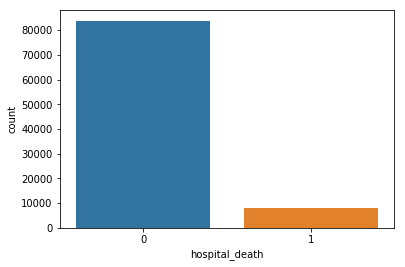

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(training_data["hospital_death"])
plt.show()

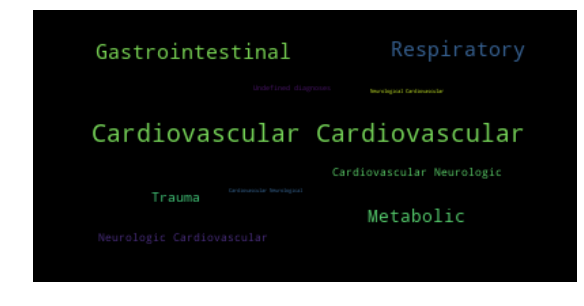

In [66]:
from wordcloud import WordCloud, ImageColorGenerator

# handling with blank space
text = " ".join(str(each) for each in training_data.apache_2_bodysystem)
text += " ".join(str(each) for each in training_data.apache_3j_bodysystem)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=10, margin=40).generate(text)
plt.figure(figsize=(15,5))
# Display the generated image:
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

### Conclusions
*-- possible conclusoins after exploring the data (ex. relevant features, data healing needed, "what else") --*

### Challenge #2 - Handling with missing data

### Chalange #3 First model
*-- list all possible models that fit well for this problem, and chose one to start in this section --*